# Code for competition

In [1]:
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

# Enable experimental feature of memory occupation growth control 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load the dataset

In [2]:
samples = []
targets = []

images_ind = [186, 532, 515, 511, 531, 222, 537, 508]
for i in range(0, len(images_ind)):
    for j in range(0, images_ind[i]):
        temp = Image.open(f'training_data_final/Species{i + 1}/{j:05}.jpg').convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0))
        label = tfk.utils.to_categorical(i, len(images_ind))
        samples.append(image)
        targets.append(label)

X = np.array(samples)
y = np.array(targets, dtype=np.uint8)
print(X.shape, X.dtype, sep=", ")
print(y.shape, y.dtype, sep=", ")

(3542, 96, 96, 3), uint8
(3542, 8), uint8


### Models metadata

In [3]:
input_shape = X.shape[1:]
image_shape = input_shape[:-1]
batch_size = 128
epochs = 200
labels = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

### Static (or offline) augmentation

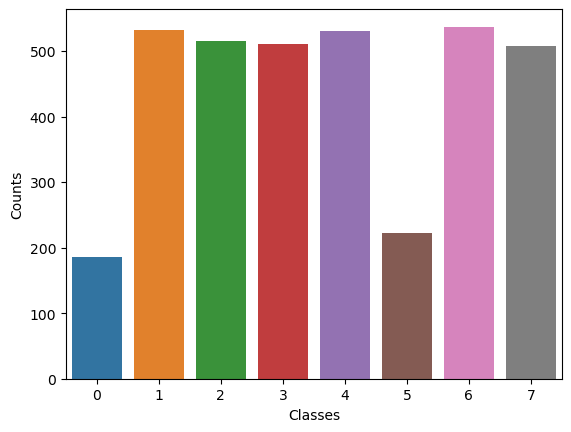

In [4]:
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

In [5]:
shift_range = 15
gen = ImageDataGenerator(rotation_range=180,
                         height_shift_range=shift_range,
                         width_shift_range=shift_range,
                         horizontal_flip=True,
                         zoom_range = 0.3,
                         fill_mode='reflect')

desired_amount = 1000

ref_list = []
aug_samples = []
aug_targets = []

for i in range(0, len(labels)):
    ref_list.append([])
  
for i in range(0, len(y)):
    ref_list[np.argmax(y[i])].append(X[i])

# Apply augmentation
for i in range(0, len(labels)):
    length = len(ref_list[i])
    to_produce = desired_amount - length
    target = tfk.utils.to_categorical(i, len(labels))
    print(f'Computing {to_produce} augmented images for target {i}')
    aug_targets_i = np.full((length, len(labels)), target)
    aug_gen_i = gen.flow(np.array(ref_list[i]), 
                         aug_targets_i,
                         batch_size=1,
                         seed=seed,
                         shuffle=True)
    for j in range(0, to_produce):
        aug_samples.append(np.squeeze(next(aug_gen_i)[0]))
        aug_targets.append(target)

# augmented dataset
X_aug = np.concatenate((X, np.array(aug_samples, dtype=np.uint8)))
y_aug = np.concatenate((y, np.array(aug_targets, dtype=np.uint8)))
print(X_aug.shape, X_aug.dtype, sep=", ")
print(y_aug.shape, y_aug.dtype, sep=", ")

Computing 814 augmented images for target 0
Computing 468 augmented images for target 1
Computing 485 augmented images for target 2
Computing 489 augmented images for target 3
Computing 469 augmented images for target 4
Computing 778 augmented images for target 5
Computing 463 augmented images for target 6
Computing 492 augmented images for target 7
(8000, 96, 96, 3), uint8
(8000, 8), uint8


### Test pre-processing

In [6]:
def preprocess(image):
    return np.array(tf.image.adjust_saturation(img, 3))
    #return np.array(tf.image.adjust_brightness(tf.image.adjust_saturation(img, 3), 0.5))

new_aug_samples = []
for img in aug_samples: 
    new_aug_samples.append(preprocess(img))

### Show some example of augmented images

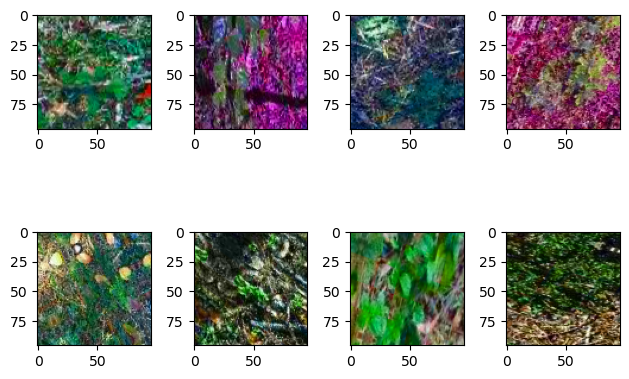

In [7]:
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col)
for i in range(num_row * num_col):
    img = random.choice(new_aug_samples)  # change to new_aug_samples to see also preprocessing effects or keep it to aug_samples
    ax = axes[i//num_col, i%num_col]
    ax.imshow(Image.fromarray(img.astype(np.uint8)))

plt.tight_layout()
plt.show()

### Apply pre-processing
All that is done here must be included in the pre-processing phase

In [8]:
temp = []
for img in X_aug: 
    temp.append(preprocess(img))

X_aug = np.array(temp)
print(X_aug.shape, X_aug.dtype, sep=", ")


(8000, 96, 96, 3), uint8


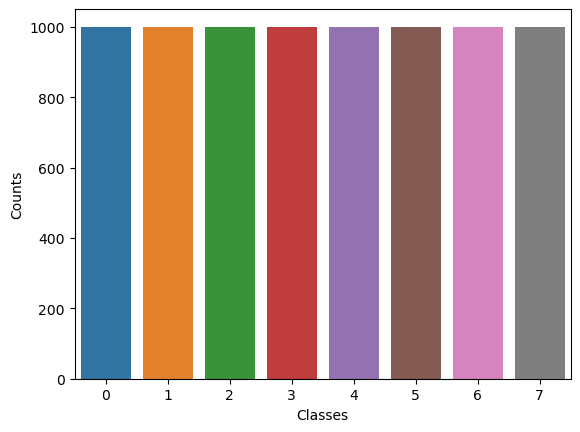

In [9]:
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y_aug], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

### Split training-validation

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, stratify=y_aug, test_size=0.15)

print(X_train.shape, X_train.dtype, y_train.shape, y_train.dtype, sep=", ")
print(X_val.shape, X_val.dtype, y_val.shape, y_val.dtype, sep=", ")

(6800, 96, 96, 3), uint8, (6800, 8), uint8
(1200, 96, 96, 3), uint8, (1200, 8), uint8


### Models definition functions

In [11]:
def build_tl_model(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.VGG16(include_top=False,
                                      weights="imagenet",
                                      input_shape=input_shape)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    '''
    x = tfkl.Dropout(0.2, seed=seed, name='gap_dropout')(x)
    
    x = tfkl.Dense(
        units = 512,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense1')(x)

    x = tfkl.Dropout(0.3, seed=seed, name='dropout1')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense2')(x)

    x = tfkl.Dropout(0.3, seed=seed, name='dropout2')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense3')(x)

    x = tfkl.Dropout(0.3, seed=seed, name='dropout3')(x)
    
    x = tfkl.Dense(
        units = 512,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense4')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='dropout4')(x)
    '''
    x = tfkl.Dense(
        units = 1024,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense5')(x)
    
    x = tfkl.Dropout(0.2, seed=seed, name='dropout5')(x)
    
    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'tl_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model


def build_conv_dense_model(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv1')(input_layer)
    
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv2')(x)
    
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'Conv3')(x)
    
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    #x = tfkl.Dropout(0.2, seed=seed, name='gap_dropout')(x)

    # end of convolutional layers
    # start of the fully connected layers
    
    #x = tfkl.Flatten()(x)
    
    x = tfkl.Dense(
        units = 512,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense1')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense2')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense3')(x)

    x = tfkl.Dense(
        units = 128,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense4')(x)

    x = tfkl.Dense(
        units = 128,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'dense5')(x)
    
    x = tfkl.Dropout(0.2, seed=seed, name='dropout')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'conv_dense_model_v1')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

### Define the model

In [12]:
model = build_conv_dense_model(input_shape)

# Use the supernet only as feature extractor (eventually apply fine tuning)
#model.get_layer('vgg16').trainable = True
#for i, layer in enumerate(model.get_layer('vgg16').layers[:-1]):
#  layer.trainable=False

model.summary()

Model: "conv_dense_model_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 256)       7168      
                                                                 
 mp1 (MaxPooling2D)          (None, 48, 48, 256)       0         
                                                                 
 conv2 (Conv2D)              (None, 48, 48, 256)       590080    
                                                                 
 mp2 (MaxPooling2D)          (None, 24, 24, 256)       0         
                                                                 
 Conv3 (Conv2D)              (None, 24, 24, 256)       590080    
                                                                 
 gap (GlobalAveragePooling2D  (None, 256)      

### Train the model

In [13]:
# Transfer learning preprocessing (to be included in the preprocessing)
#from tensorflow.keras.applications.vgg16 import preprocess_input
#X_train_tl = np.array(preprocess_input(X_train), dtype=np.uint8)
#X_val_tl = np.array(preprocess_input(X_val), dtype=np.uint8)

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
).history

Epoch 1/400
213/213 [==============================] - 107s 482ms/step - loss: 24.8340 - accuracy: 0.2163 - val_loss: 1.6962 - val_accuracy: 0.3600
Epoch 2/400
213/213 [==============================] - 103s 481ms/step - loss: 1.6924 - accuracy: 0.3590 - val_loss: 1.6064 - val_accuracy: 0.3958
Epoch 3/400
213/213 [==============================] - 105s 491ms/step - loss: 1.5463 - accuracy: 0.4187 - val_loss: 1.4591 - val_accuracy: 0.4558
Epoch 4/400
213/213 [==============================] - 107s 500ms/step - loss: 1.4301 - accuracy: 0.4675 - val_loss: 1.3982 - val_accuracy: 0.4683
Epoch 5/400
213/213 [==============================] - 106s 500ms/step - loss: 1.3656 - accuracy: 0.4860 - val_loss: 1.1914 - val_accuracy: 0.5542
Epoch 6/400
213/213 [==============================] - 108s 506ms/step - loss: 1.2748 - accuracy: 0.5231 - val_loss: 1.2068 - val_accuracy: 0.5417
Epoch 7/400
213/213 [==============================] - 108s 505ms/step - loss: 1.2318 - accuracy: 0.5485 - val_loss: 

### Plot training results

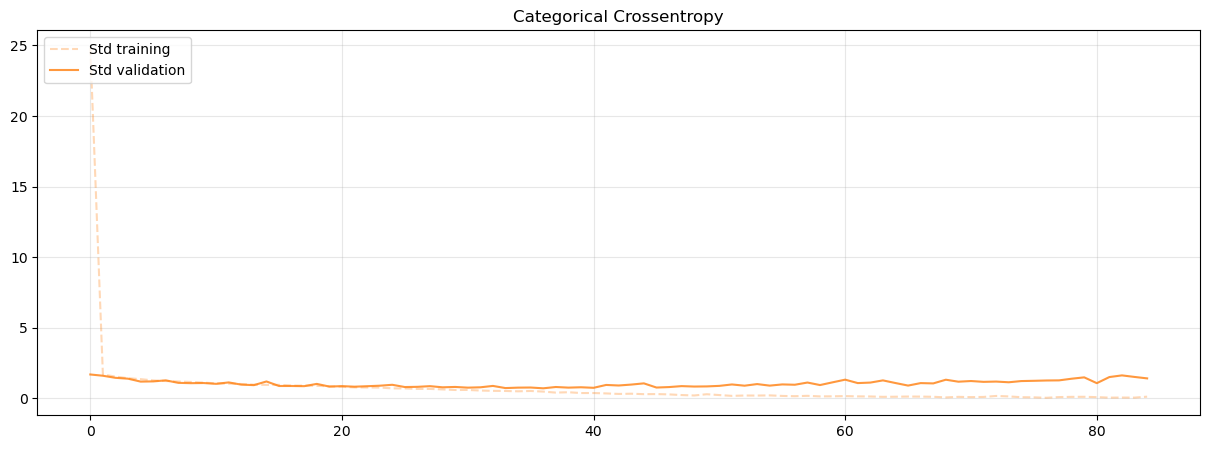

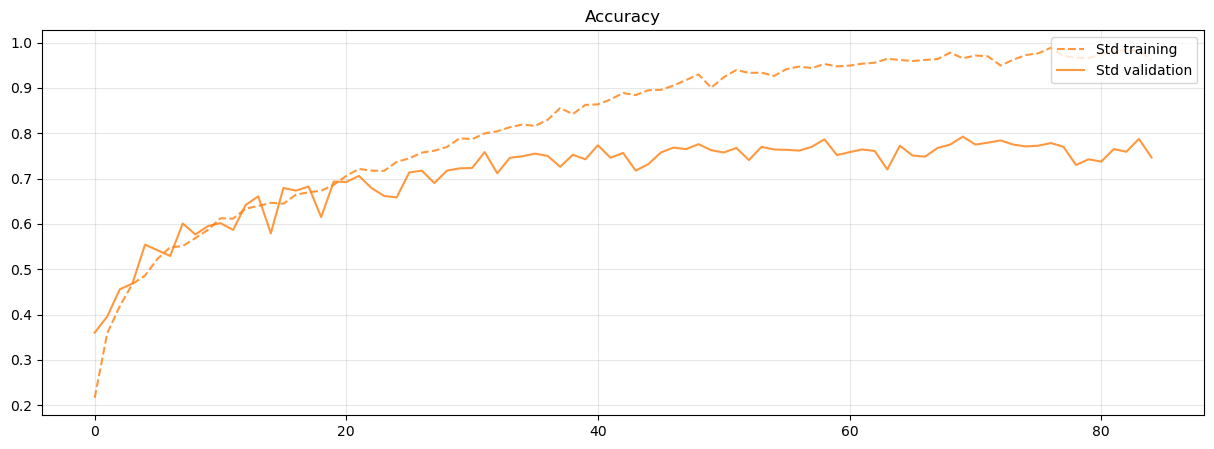

In [14]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Plot the confusion matrix (evaluated on the validation set)

38/38 [==============================] - 5s 120ms/step
Accuracy: 0.7925
Precision: 0.7972
Recall: 0.7925
F1: [0.7692 0.7697 0.8    0.7932 0.7986 0.894  0.8702 0.651 ]


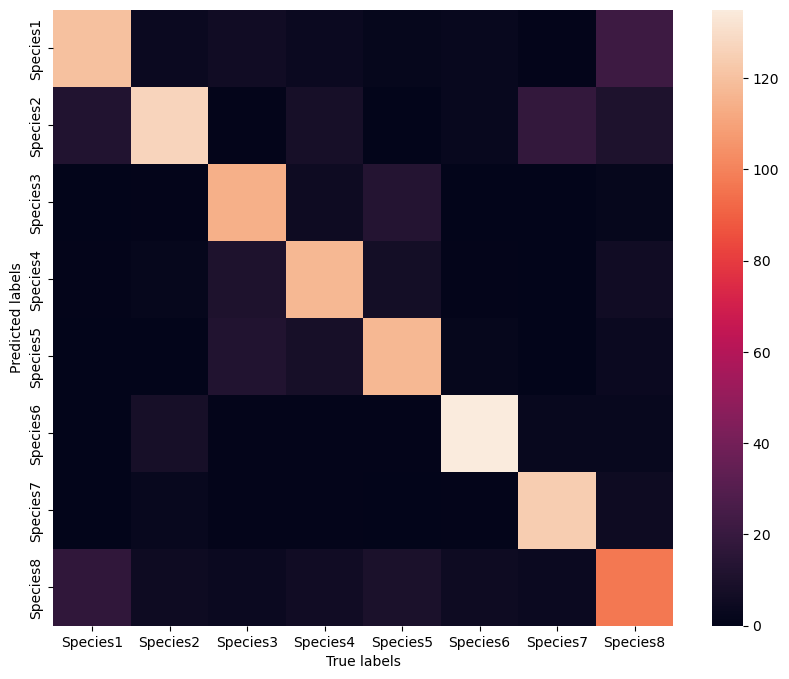

In [15]:
predictions = model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Save the model

In [17]:
num_test_samples = 120

test_samples = []
test_targets = []
for i in range(0, len(labels)):
    for j in range(0, num_test_samples):
        test_samples.append(preprocess(ref_list[i][j]))
        test_targets.append(tfk.utils.to_categorical(i, len(labels)))
X_test = np.array(test_samples)
y_test = np.array(test_targets)


restored_model = tfk.models.load_model('best_model')
restored_loss, restored_acc = restored_model.evaluate(X_test, y_test, verbose=2)  #TODO: not right because validation set can change
loss, acc = model.evaluate(X_test, y_test, verbose=2)
if acc > restored_acc:  # know that this is conceptually wrong
    print("Model improved!")
    model.save('best_model')
else:
    print("No improvement!")

30/30 - 4s - loss: 10.7756 - accuracy: 0.1250 - 4s/epoch - 135ms/step
30/30 - 4s - loss: 10.7756 - accuracy: 0.1250 - 4s/epoch - 124ms/step
No improvement!
